# Long Period with TLS

* Search database for long-period TOIs (30-200 days)
* Single target analysis with full diagnostic plots

blue line is TLS model overlaid on binned data
* Batch analysis of top 10 candidates

C:\Users\Coral14\AppData\Local\Temp\ipykernel_22128\1871184824.py:9: DeprecationWarning: the ``nasa_exoplanet_archive`` module has been moved to astroquery.ipac.nexsci.nasa_exoplanet_archive, please update your imports.
  from astroquery.nasa_exoplanet_archive import NasaExoplanetArchive


Lightkurve version: 2.4.0
TLS version: 1.0.31
Ready for long-period planet search!

TESS LONG-PERIOD EXOPLANET SEARCH WITH TLS


1. SEARCH TOI DATABASE
SEARCHING FOR LONG-PERIOD TOIs
Period range: 30 - 200 days
Minimum sectors: 3
This may take awhile!

Found 232 TOIs with periods between 30 - 200 days

Top 15 candidates:
    TOI    TIC_ID  Period(days)  Radius(Re)     Tmag
 790.01 308994098    199.577907    6.993604  8.99140
1856.01 224313733    197.033625   12.071300 10.93740
4510.01 340458804    194.243286    4.471485 10.36070
 809.01 149301575    183.458919    3.379417 10.30460
4305.01 372068780    183.001911    5.593121  7.84590
2286.01 237201858    179.403171    3.747235  9.85236
2074.01 158075010    177.583051    3.595373  8.38689
2091.01 219778329    177.218887    2.032311  8.15290
5723.01 235901733    170.646515   12.850452 12.88570
7296.01 233735354    170.336391   11.691600 12.87710
2299.01 362220495    165.003158    4.517045  9.86300
6957.01  30853990    160.676021    3.2160

100%|██████████████████████████████████████████████████████████████| 72897/72897 periods | 17:52<00:00


Searching for best T0 for period 107.37772 days


100%|██████████████████████████████████████████████████████████| 46774/46774 [01:36<00:00, 482.21it/s]



TLS RESULTS:
  Period: 107.3777 days
  Duration: 0.51 hours
  Depth: 997947.8 ppm
  SDE: 27.1
  SNR: 1.1
  Distinct transits: 5
  Odd-even mismatch: 0.795
  Rp/Rs: 0.0407
  Estimated R_planet: 3.14 R_Earth


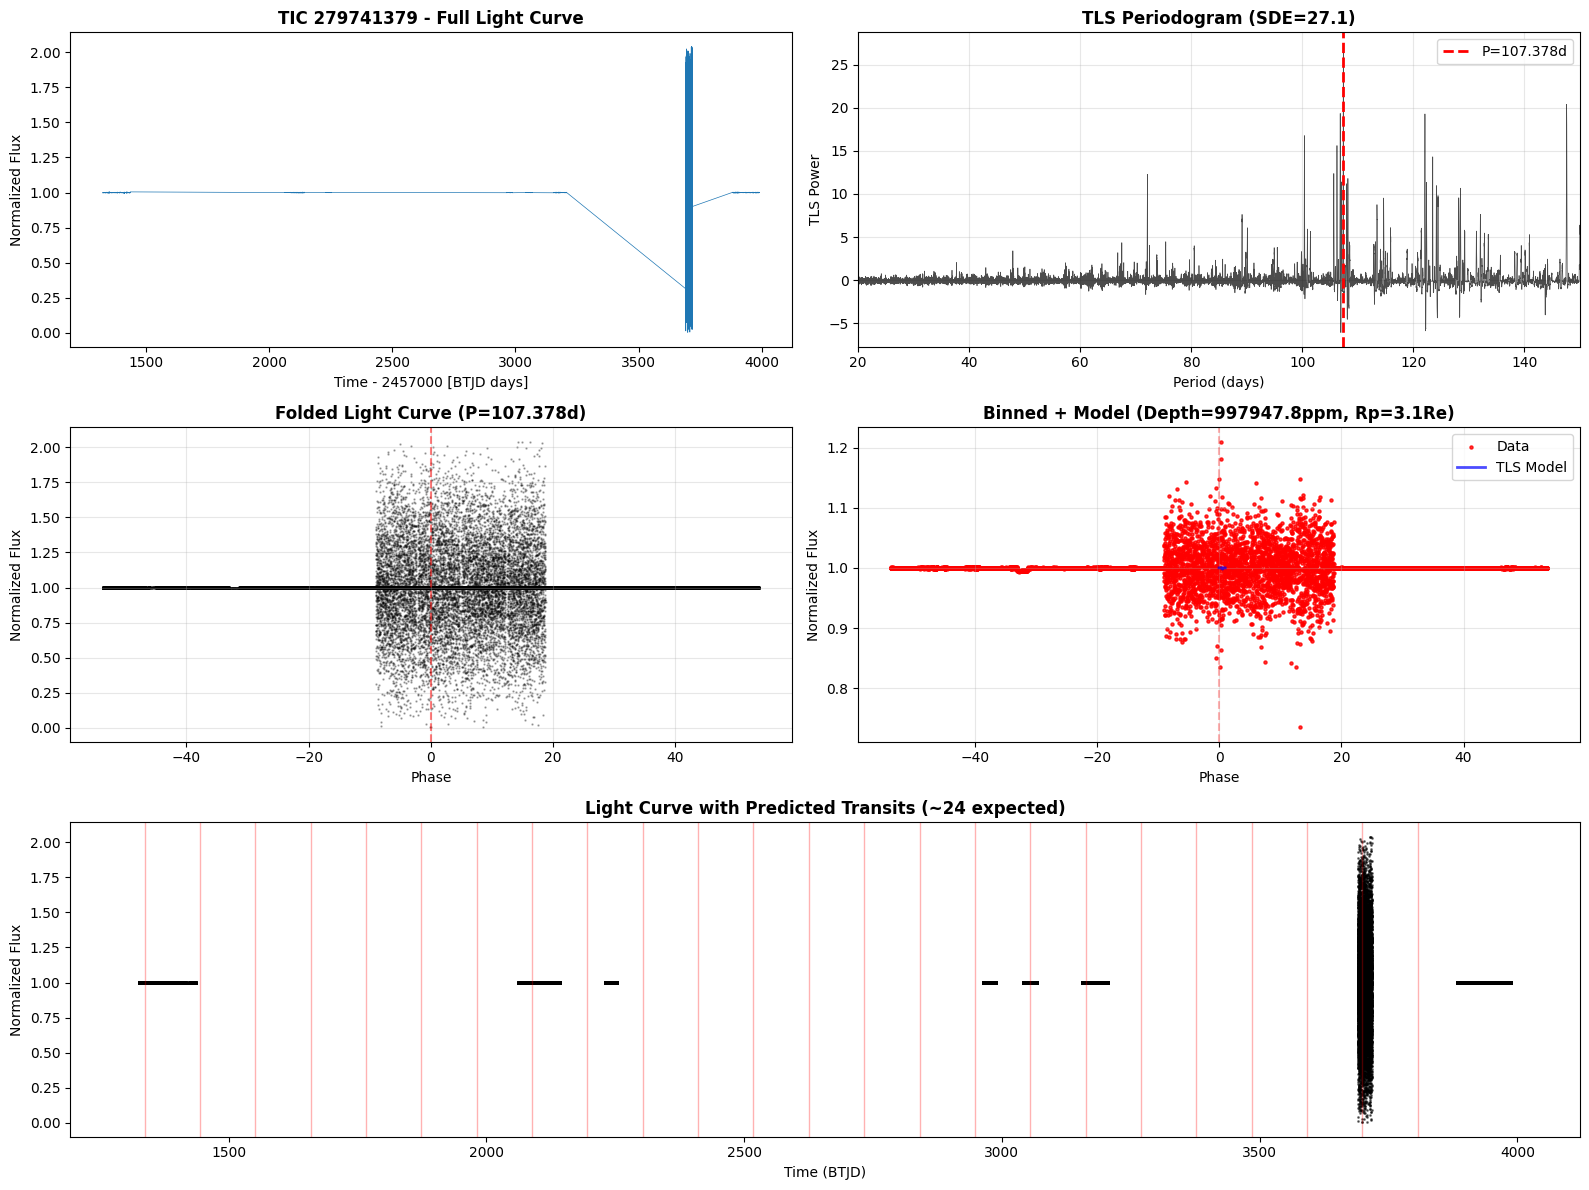


TIC 279741379: ✗ LIKELY FALSE POSITIVE
  → Depth too large (997948 ppm = 99.8%) - likely eclipsing binary
  → Low SNR (1.1) - noisy detection
  → High odd-even mismatch (0.795) - possible binary


3. BATCH ANALYSIS OF TOP CANDIDATES
Using candidates from database search...

BATCH TLS ANALYSIS: 10 TARGETS

[1/10] Processing TIC 308994098...

ANALYZING TIC 308994098 WITH TLS
Found 24 sectors
  Sector 1: 1200 clean points
  Sector 4: 876 clean points
  Sector 8: 819 clean points
  Sector 9: 988 clean points
  Sector 10: 974 clean points
  Sector 11: 999 clean points
  Sector 28: 3169 clean points
  Sector 31: 3216 clean points
  Sector 34: 3260 clean points
  Sector 36: 2940 clean points
  Sector 37: 3163 clean points
  Sector 38: 3581 clean points
  Sector 61: 9883 clean points
  Sector 62: 9806 clean points
  Sector 63: 10426 clean points
  Sector 64: 10942 clean points
  Sector 65: 6414 clean points
  Sector 68: 10415 clean points
  Sector 69: 8530 clean points
  Sector 88: 10934 clea

  0%|                                                                      | 0/44027 periods | 00:00<?

In [ ]:
import os
# Abbreviate beginning of line so window doesn't get stuck
os.environ['LIGHTKURVE_CACHE'] = "C:/lkcache"

import lightkurve as lk
from lightkurve import search_tesscut
from transitleastsquares import transitleastsquares
from astroquery.mast import Catalogs
from astroquery.nasa_exoplanet_archive import NasaExoplanetArchive
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

print("Lightkurve version:", lk.__version__)
print("TLS version: 1.0.31")
print("Ready for long-period planet search!")


def get_stellar_params(tic_id):
    """
    Get stellar parameters from TIC for TLS.
    Returns solar values if data is missing.
    """
    try:
        catalog_data = Catalogs.query_object(f"TIC {tic_id}", catalog="TIC", radius=0.001)
        
        if len(catalog_data) == 0:
            return {'radius': 1.0, 'mass': 1.0, 'teff': 5500, 'logg': 4.5}
        
        def get_valid_param(data, key, default):
            try:
                value = data[key][0]
                if np.ma.is_masked(value) or np.isnan(value) or value <= 0:
                    return default
                return float(value)
            except:
                return default
        
        stellar_params = {
            'radius': get_valid_param(catalog_data, 'rad', 1.0),
            'mass': get_valid_param(catalog_data, 'mass', 1.0),
            'teff': get_valid_param(catalog_data, 'Teff', 5500),
            'logg': get_valid_param(catalog_data, 'logg', 4.5)
        }
        
        return stellar_params
        
    except Exception as e:
        return {'radius': 1.0, 'mass': 1.0, 'teff': 5500, 'logg': 4.5}


def search_long_periods_tois(min_period=30, max_period=200, min_sectors=3):
    """
    Search NASA Exoplanet Archive for TOIs with long orbital periods
    """
    print("="*70)
    print("SEARCHING FOR LONG-PERIOD TOIs")
    print("="*70)
    print(f"Period range: {min_period} - {max_period} days")
    print(f"Minimum sectors: {min_sectors}")
    print("This may take awhile!\n")
    
    try:
        toi_table = NasaExoplanetArchive.query_criteria(
            table="TOI",
            select="toi, tid, pl_orbper, pl_rade, st_tmag",
            where=f"pl_orbper > {min_period} and pl_orbper < {max_period}"
        )
        
        df = toi_table.to_pandas()
        df = df.dropna(subset=['tid', 'pl_orbper'])
        df["tic_id"] = df["tid"].astype(int)
        df = df.sort_values(['pl_orbper', 'st_tmag'], ascending=[False, True])
        
        num_candidates = 15
        
        print(f"Found {len(df)} TOIs with periods between {min_period} - {max_period} days")
        print(f"\nTop {num_candidates} candidates:")
        
        display_columns = ['toi', 'tic_id', 'pl_orbper', 'pl_rade', 'st_tmag']
        summary = df[display_columns].head(num_candidates).copy()
        summary.columns = ['TOI', 'TIC_ID', 'Period(days)', 'Radius(Re)', 'Tmag']
        
        print(summary.to_string(index=False))
        return df
    
    except Exception as e:
        print(f"Error querying NASA Exoplanet Archive: {e}")
        return None


def analyze_target_tls(tic_id, period_min=20, period_max=200, plot=True):
    """
    Analyze a target using Transit Least Squares (TLS).
    Returns results and light curve.
    """
    target = f"TIC {tic_id}"
    print(f"\n{'='*70}")
    print(f"ANALYZING {target} WITH TLS")
    print(f"{'='*70}")
    
    # Download data
    try:
        search = lk.search_tesscut(target)
        if len(search) == 0:
            print(f"No TESS data found")
            return None, None
        print(f"Found {len(search)} sectors")
        tpfs = search.download_all(cutout_size=5)
    except Exception as e:
        print(f"Error downloading: {e}")
        return None, None
    
    # Extract light curves
    lc_list = []
    for tpf in tpfs:
        try:
            if tpf.flux.size == 0:
                continue
            
            # Select aperture
            mask = tpf.create_threshold_mask(threshold=3)
            if mask.sum() == 0:
                mask = tpf.create_threshold_mask(threshold=1)
            if mask.sum() == 0:
                mask = tpf.pipeline_mask
            
            lc = tpf.to_lightcurve(aperture_mask=mask)
            
            # Clean data
            lc = lc[lc.quality == 0]
            lc = lc.remove_nans()
            lc = lc.remove_outliers(sigma=5)
            
            if len(lc.time) < 500:
                continue
            
            # Flatten
            lc = lc.flatten(window_length=301)
            lc = lc.remove_outliers(sigma=4)
            
            # Sigma clip
            flux_median = np.median(lc.flux.value)
            flux_std = np.std(lc.flux.value)
            mask_good = np.abs(lc.flux.value - flux_median) < 3 * flux_std
            lc = lc[mask_good]
            
            # Remove negative flux
            lc = lc[lc.flux.value > 0]
            
            if len(lc.time) < 500:
                print(f"  Sector {tpf.sector}: too few points after cleaning")
                continue
            
            lc_list.append(lc)
            print(f"  Sector {tpf.sector}: {len(lc.time)} clean points")
            
        except Exception as e:
            print(f"  Sector {tpf.sector}: {e}")
            continue
    
    if len(lc_list) == 0:
        print(f"No valid light curves")
        return None, None
    
    print(f"\nExtracted {len(lc_list)} light curves")
    
    # Combine light curves
    all_lc = lc_list[0]
    for lc in lc_list[1:]:
        all_lc = all_lc.append(lc)
    
    all_lc = all_lc.normalize()
    
    # Data quality check
    print(f"\nData Quality Check:")
    print(f"  Flux median: {np.median(all_lc.flux.value):.4f}")
    print(f"  Flux std: {np.std(all_lc.flux.value):.4f}")
    print(f"  Min flux: {np.min(all_lc.flux.value):.4f}")
    print(f"  Max flux: {np.max(all_lc.flux.value):.4f}")
    
    time_baseline = all_lc.time.value[-1] - all_lc.time.value[0]
    print(f"\nTime baseline: {time_baseline:.1f} days")
    print(f"Total data points: {len(all_lc.time)}")
    
    # Get stellar parameters
    print(f"\nQuerying stellar parameters...")
    stellar_params = get_stellar_params(tic_id)
    print(f"  R_star: {stellar_params['radius']:.2f} Rsun")
    print(f"  M_star: {stellar_params['mass']:.2f} Msun")
    
    # Run TLS
    print(f"\nRunning TLS search (period range: {period_min}-{period_max} days)...")
    print("This may take a few minutes for long periods...")
    
    time = all_lc.time.value
    flux = all_lc.flux.value
    flux_err = all_lc.flux_err.value
    
    model = transitleastsquares(time, flux, flux_err)
    
    tls_kwargs = {
        'period_min': period_min,
        'period_max': period_max,
        'n_transits_min': 2,
        'R_star': stellar_params['radius'],
        'M_star': stellar_params['mass'],
        'R_star_min': stellar_params['radius'] * 0.8,
        'R_star_max': stellar_params['radius'] * 1.2,
        'M_star_min': stellar_params['mass'] * 0.8,
        'M_star_max': stellar_params['mass'] * 1.2
    }
    
    tls_result = model.power(**tls_kwargs)
    
    # Check if TLS found valid result
    if np.isnan(tls_result.period) or np.isnan(tls_result.T0) or tls_result.SDE < 5:
        print(f"\n⚠️ WARNING: TLS failed to find significant transit")
        print(f"  Period: {tls_result.period}")
        print(f"  SDE: {tls_result.SDE:.1f} (need > 7 for confidence)")
        return None, all_lc
    
    # Extract results
    results = {
        'tic_id': tic_id,
        'period': tls_result.period,
        'duration': tls_result.duration,
        't0': tls_result.T0,
        'power': tls_result.power.max(),
        'SDE': tls_result.SDE,
        'depth': tls_result.depth,
        'depth_ppm': tls_result.depth * 1e6,
        'snr': tls_result.snr,
        'n_transits': tls_result.distinct_transit_count,
        'odd_even_mismatch': tls_result.odd_even_mismatch,
        'rp_rs': tls_result.rp_rs if hasattr(tls_result, 'rp_rs') else np.sqrt(tls_result.depth),
        'time_baseline': time_baseline,
        'n_points': len(time),
        'R_star': stellar_params['radius'],
        'M_star': stellar_params['mass']
    }
    
    print(f"\n{'='*70}")
    print("TLS RESULTS:")
    print(f"{'='*70}")
    print(f"  Period: {results['period']:.4f} days")
    print(f"  Duration: {results['duration']*24:.2f} hours")
    print(f"  Depth: {results['depth_ppm']:.1f} ppm")
    print(f"  SDE: {results['SDE']:.1f}")
    print(f"  SNR: {results['snr']:.1f}")
    print(f"  Distinct transits: {results['n_transits']}")
    print(f"  Odd-even mismatch: {results['odd_even_mismatch']:.3f}")
    print(f"  Rp/Rs: {results['rp_rs']:.4f}")
    
    # Estimate planet radius
    R_planet_earth = results['rp_rs'] * stellar_params['radius'] * 109.1
    print(f"  Estimated R_planet: {R_planet_earth:.2f} R_Earth")
    
    # Plot results
    if plot:
        fig = plt.figure(figsize=(16, 12))
        
        # Full light curve
        ax1 = plt.subplot(3, 2, 1)
        all_lc.plot(ax=ax1)
        ax1.set_title(f"{target} - Full Light Curve", fontsize=12, fontweight='bold')
        
        # TLS Periodogram
        ax2 = plt.subplot(3, 2, 2)
        ax2.plot(tls_result.periods, tls_result.power, 'k-', lw=0.5, alpha=0.7)
        ax2.axvline(results['period'], color='red', linestyle='--', lw=2, 
                    label=f"P={results['period']:.3f}d")
        ax2.set_xlabel("Period (days)")
        ax2.set_ylabel("TLS Power")
        ax2.set_title(f"TLS Periodogram (SDE={results['SDE']:.1f})", fontsize=12, fontweight='bold')
        ax2.legend()
        ax2.grid(alpha=0.3)
        ax2.set_xlim(period_min, period_max)
        
        # Folded light curve (scatter)
        ax3 = plt.subplot(3, 2, 3)
        lc_fold = all_lc.fold(period=results['period'], epoch_time=results['t0'])
        lc_fold.scatter(ax=ax3, s=2, alpha=0.3, c='black')
        ax3.set_title(f"Folded Light Curve (P={results['period']:.3f}d)", 
                     fontsize=12, fontweight='bold')
        ax3.set_xlabel("Phase")
        ax3.set_ylabel("Normalized Flux")
        ax3.axvline(0, color='red', ls='--', alpha=0.5)
        ax3.grid(alpha=0.3)
        
        # Folded light curve (binned) with TLS model
        ax4 = plt.subplot(3, 2, 4)
        lc_fold_binned = lc_fold.bin(time_bin_size=0.01)
        lc_fold_binned.scatter(ax=ax4, s=20, c='red', alpha=0.8, label='Data')
        
        # Plot TLS model
        phase = tls_result.folded_phase
        model_flux = tls_result.model_folded_model
        sort_idx = np.argsort(phase)
        ax4.plot(phase[sort_idx], model_flux[sort_idx], 'b-', lw=2, 
                label='TLS Model', alpha=0.7)
        
        ax4.set_title(f"Binned + Model (Depth={results['depth_ppm']:.1f}ppm, Rp={R_planet_earth:.1f}Re)", 
                     fontsize=12, fontweight='bold')
        ax4.set_xlabel("Phase")
        ax4.set_ylabel("Normalized Flux")
        ax4.axvline(0, color='red', ls='--', alpha=0.3)
        ax4.legend()
        ax4.grid(alpha=0.3)
        
        # Transit locations
        ax5 = plt.subplot(3, 2, (5, 6))
        n_transits = int(time_baseline / results['period'])
        transit_times = results['t0'] + results['period'] * np.arange(n_transits)
        ax5.plot(time, flux, 'k.', ms=2, alpha=0.5)
        for tt in transit_times:
            if time[0] <= tt <= time[-1]:
                ax5.axvline(tt, color='red', alpha=0.3, lw=1)
        ax5.set_xlabel("Time (BTJD)")
        ax5.set_ylabel("Normalized Flux")
        ax5.set_title(f"Light Curve with Predicted Transits (~{n_transits} expected)", 
                     fontsize=12, fontweight='bold')
        
        plt.tight_layout()
        plt.show()
    
    return results, all_lc


def vet_detection_tls(results):
    """
    Vet TLS detection for long-period planets
    """
    period = results['period']
    depth_ppm = results['depth_ppm']
    duration_hrs = results['duration'] * 24
    sde = results['SDE']
    snr = results['snr']
    n_transits = results['n_transits']
    odd_even = results['odd_even_mismatch']
    
    verdict = "GOOD"
    reasons = []
    
    # Depth checks
    if depth_ppm > 20000:  # > 2%
        verdict = "BAD"
        reasons.append(f"Depth too large ({depth_ppm:.0f} ppm = {depth_ppm/10000:.1f}%) - likely eclipsing binary")
    
    # Period artifact checks
    sector_length = 27.4
    for mult in [1, 2, 3, 4, 5]:
        if abs(period - mult * sector_length) < 2.0:
            verdict = "BAD"
            reasons.append(f"Period matches {mult}× sector length ({mult*sector_length:.1f}d) - instrumental artifact")
            break
    
    # Duration checks
    if duration_hrs < 0.5:
        verdict = "BAD"
        reasons.append(f"Duration too short ({duration_hrs:.1f} hrs) - suspicious")
    
    # TLS-specific: SDE check (most important!)
    if sde < 7:
        verdict = "BAD"
        reasons.append(f"Low SDE ({sde:.1f}) - signal not significant (need > 7)")
    elif sde < 9:
        if verdict != "BAD":
            verdict = "SUSPICIOUS"
        reasons.append(f"Moderate SDE ({sde:.1f}) - needs confirmation")
    
    # SNR check
    if snr < 5:
        if verdict != "BAD":
            verdict = "SUSPICIOUS"
        reasons.append(f"Low SNR ({snr:.1f}) - noisy detection")
    
    # Transit count for long periods
    if n_transits < 3:
        if verdict != "BAD":
            verdict = "SUSPICIOUS"
        reasons.append(f"Only {n_transits} transits detected - limited data")
    
    # Odd-even mismatch (binary check)
    if odd_even > 0.1:
        if verdict != "BAD":
            verdict = "SUSPICIOUS"
        reasons.append(f"High odd-even mismatch ({odd_even:.3f}) - possible binary")
    
    # Yellow flags
    if verdict != "BAD":
        if depth_ppm > 10000:  # 1-2%
            verdict = "SUSPICIOUS"
            reasons.append(f"Large depth ({depth_ppm:.0f} ppm) - could be giant planet or binary")
        
        if depth_ppm < 100:
            verdict = "SUSPICIOUS"
            reasons.append(f"Very shallow ({depth_ppm:.0f} ppm) - hard to confirm")
        
        if duration_hrs > 12:
            verdict = "SUSPICIOUS"
            reasons.append(f"Long duration ({duration_hrs:.1f} hrs) - unusual for planet")
    
    # Good candidate
    if len(reasons) == 0 or (len(reasons) == 1 and 'SDE' in reasons[0] and sde >= 9):
        reasons.append(f"Strong detection: P={period:.1f}d, depth={depth_ppm:.0f}ppm, SDE={sde:.1f}, {n_transits} transits")
    
    return verdict, reasons


def print_vet_result_tls(tic_id, results):
    """Print vetting results"""
    verdict, reasons = vet_detection_tls(results)
    
    if verdict == "GOOD":
        color_msg = "✓ GOOD CANDIDATE"
    elif verdict == "SUSPICIOUS":
        color_msg = "⚠ SUSPICIOUS - REVIEW CAREFULLY"
    else:
        color_msg = "✗ LIKELY FALSE POSITIVE"
    
    print(f"\n{'='*70}")
    print(f"TIC {tic_id}: {color_msg}")
    print(f"{'='*70}")
    for reason in reasons:
        print(f"  → {reason}")


def batch_analyze_tls(tic_ids, period_min=20, period_max=200, save_results=True):
    """
    Batch analyze multiple targets with TLS
    """
    results_list = []
    
    print(f"\n{'='*70}")
    print(f"BATCH TLS ANALYSIS: {len(tic_ids)} TARGETS")
    print(f"{'='*70}")
    
    for i, tic_id in enumerate(tic_ids, 1):
        print(f"\n[{i}/{len(tic_ids)}] Processing TIC {tic_id}...")
        
        result, lc = analyze_target_tls(tic_id, period_min, period_max, plot=False)
        
        if result is not None:
            # Vet detection
            verdict, reasons = vet_detection_tls(result)
            result['verdict'] = verdict
            results_list.append(result)
            
            print(f"  ✓ P={result['period']:.3f}d, Depth={result['depth_ppm']:.1f}ppm, SDE={result['SDE']:.1f}")
            print_vet_result_tls(tic_id, result)
        else:
            print(f"  ✗ Failed to detect transit for TIC {tic_id}")
    
    # Create summary
    if len(results_list) > 0:
        df_results = pd.DataFrame(results_list)
        df_results = df_results.sort_values('SDE', ascending=False)  # Sort by SDE
        
        print(f"\n{'='*70}")
        print("BATCH ANALYSIS COMPLETE")
        print(f"{'='*70}")
        print(f"\nSuccessfully analyzed {len(df_results)} targets:\n")
        
        summary_cols = ['tic_id', 'period', 'depth_ppm', 'SDE', 'snr', 'n_transits', 'verdict']
        print(df_results[summary_cols].to_string(index=False))
        
        # Vetting summary
        n_good = (df_results['verdict'] == 'GOOD').sum()
        n_suspicious = (df_results['verdict'] == 'SUSPICIOUS').sum()
        n_bad = (df_results['verdict'] == 'BAD').sum()
        
        print(f"\n{'='*70}")
        print("VETTING SUMMARY:")
        print(f"{'='*70}")
        print(f"  ✓ Good candidates: {n_good}")
        print(f"  ⚠ Suspicious: {n_suspicious}")
        print(f"  ✗ Likely false positives: {n_bad}")
        
        if save_results:
            filename = "tess_tls_long_period_results.csv"
            df_results.to_csv(filename, index=False)
            print(f"\n💾 Results saved to {filename}")
        
        return df_results
    else:
        print("\n⚠️ No successful analyses")
        return None


# MAIN EXECUTION
if __name__ == "__main__":
    
    print("\n" + "="*70)
    print("TESS LONG-PERIOD EXOPLANET SEARCH WITH TLS")
    print("="*70)
    
    # Search for candidates in database
    print("\n\n1. SEARCH TOI DATABASE")
    candidates_df = search_long_periods_tois(min_period=30, max_period=200)
    
    # Analyze single target
    print("\n\n2. ANALYZE SINGLE TARGET")
    single_result, single_lc = analyze_target_tls(279741379, period_min=20, period_max=150)
    
    if single_result is not None:
        print_vet_result_tls(279741379, single_result)
    
    # Batch analyze top candidates
    print("\n\n3. BATCH ANALYSIS OF TOP CANDIDATES")
    
    if candidates_df is not None:
        print("Using candidates from database search...")
        top_tics = candidates_df['tic_id'].head(10).tolist()
    else:
        print("Database search failed - using manual list...")
        top_tics = [279741379, 425997655, 52368076, 231663901, 393818]
    
    batch_results = batch_analyze_tls(top_tics, period_min=20, period_max=150)